# Agriculture Detection with Keras
This notebook focuses on the TensorFlow/Keras workflow for loading satellite imagery data, batching it, and preparing it for model training.

In [206]:
# Import Required Libraries
import os
import importlib
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Local imports
import utils.main_utils as main_utils
importlib.reload(main_utils)
from utils.main_utils import check_skillnetwork_extraction, shuffle_data
import utils.keras_ai_utils as keras_ai_utils
importlib.reload(keras_ai_utils)
from utils.keras_ai_utils import (
    set_tf_processing_env,
    create_keras_datasets,
    display_keras_batch,
    configure_keras_for_performance,
    keras_custom_data_generator,
    display_custom_keras_batch,
    create_generators,
    build_keras_model,
    display_keras_history,
    evaluate_keras_model
)

<!-- ## Download and Extract Data
Download the satellite images dataset and extract it to the `data/` directory if it is not already available. -->

In [207]:
# Download and extract data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar'
extract_dir = './data/'
model_dir = './models/'
os.makedirs(extract_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
dataset_path = os.path.join(extract_dir, 'images_dataSAT')
await check_skillnetwork_extraction(extract_dir, url)

Checking write permissions for skillsnetwork extraction...
Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to 'data'


## Label and Shuffle Data
Aggregate image paths and labels for agricultural and non-agricultural classes, then shuffle for downstream batching.

In [208]:
# Label and shuffle data
base_dir = './data/images_dataSAT/'
dir_non_agri_name = os.path.join(base_dir, 'class_0_non_agri')
dir_agri_name = os.path.join(base_dir, 'class_1_agri')

all_image_paths, all_labels = shuffle_data(dir_non_agri_name, dir_agri_name)

Shuffling data...


## Custom Data Generator vs Keras Dataset

Displaying a custom data batch...
Generating custom data batches...
Images batch shape: (8, 64, 64, 3)
Labels batch shape: (8,)
Creating Keras datasets...
Found 6000 files belonging to 2 classes.
Using 4800 files for training.


/Users/isaacdavis/Desktop/PersonalStuff/MyProjects/GitHub/AI/agriculture_detection/env/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Displaying a Keras data batch...


2025-11-07 14:01:39.105972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


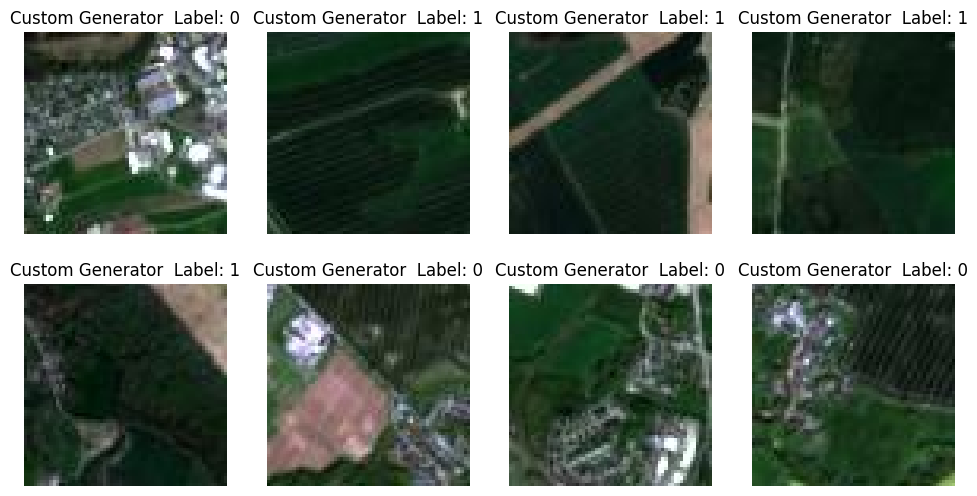

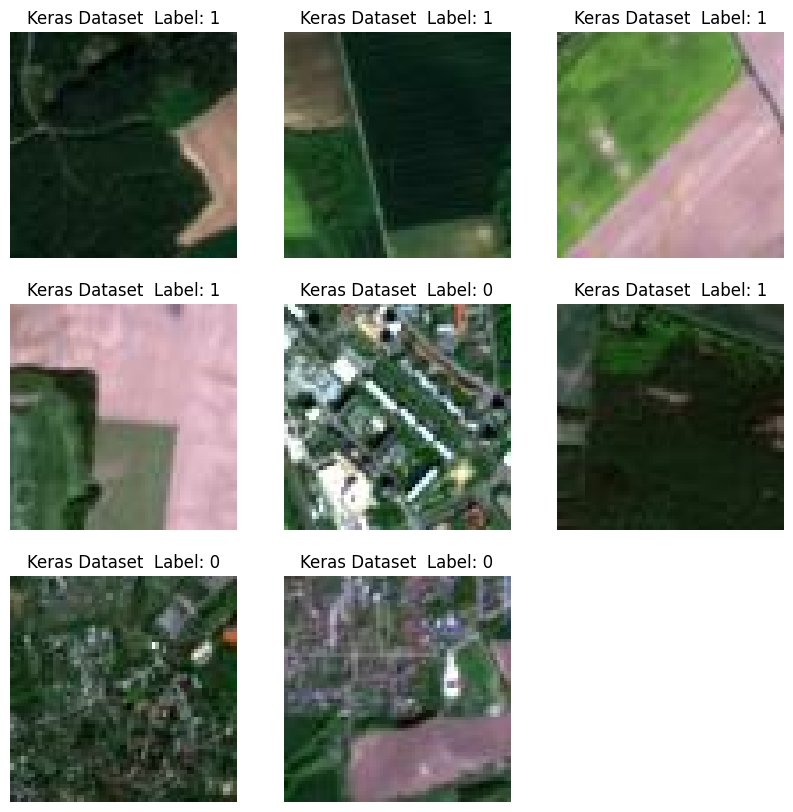

In [209]:
# Custom generator for custom batching
batch_size = 8
data_generator = keras_custom_data_generator(
    image_paths=all_image_paths,
    labels=all_labels,
    batch_size=batch_size,
)
display_custom_keras_batch(data_generator, batch_size, title='Custom Generator')

# Create and inspect Keras datasets
img_size = (64, 64)
train_ds, val_ds = create_keras_datasets(
    base_dir=base_dir,
    img_size=img_size,
    batch_size=batch_size,
)
display_keras_batch(batch_size, train_ds, title='Keras Dataset')

## Configure Keras Pipelines for Performance
Apply caching, shuffling, and prefetching strategies to optimize input pipelines.

In [210]:
# Optimize datasets for performant training
train_ds, val_ds = configure_keras_for_performance(train_ds, val_ds)

Configuring Keras datasets for performance...
Cause: could not parse the source code of <function configure_keras_for_performance.<locals>.<lambda> at 0x1452bcd30>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: (data_augmentation(x, training=True), y)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function configure_keras_for_performance.<locals>.<lambda> at 0x1452bcd30>: no matching AST found among candidates:
# coding=utf-8
lambda x, y: (data_augmentation(x, training=True), y)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Setup Tensorflow Processing Environment

In [211]:
device, fnames = set_tf_processing_env(dataset_path)

Setting TensorFlow processing environment...
Device available for training: cpu
Setting TensorFlow random seed to 1...
Getting file names from dataset...
total files in dataset: 6000
./data/images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_5974.jpg
./data/images_dataSAT/class_1_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UPE_20250427T170513.SAFE_23339.jpg
./data/images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_15163.jpg
./data/images_dataSAT/class_0_non_agri/tile_S2A_MSIL2A_20250427T101701_N0511_R065_T32UQB_20250427T170513.SAFE_8291.jpg


## Define Hyperparameters

In [212]:
# Model Architecture Parameters
img_w, img_h = 64, 64                  # Image width and height
n_channels = 3                         # Number of image channels (e.g., 3 for RGB)
hidden_activation = 'relu'             # Activation function for hidden layers
output_activation = 'sigmoid'          # Activation function for the output layer
padding = 'same'                       # Padding strategy for convolutional layers
strides = (1, 1)                       # Strides for convolutional layers
kernel_size = (5, 5)                   # Kernel size for convolutional layers
kernel_initializer = HeUniform()       # Initializer for the kernel weights
kernel_regularizer = l2(0.001)         # Regularizer for the kernel weights
dropout = .5                           # Dropout rate for regularization
filter_base = 32                       # Base number of filters for convolutional layers
unit_base = 128                        # Base number of units for dense layers
output_units = 1                       # Number of units in the output layer
conv_block_num = 3                     # Number of convolutional blocks
dense_block_num = 1                    # Number of dense blocks
pool_size = (2, 2)                     # Pool size for MaxPooling layers
pool_strides = (2, 2)                  # Strides for MaxPooling layers

# Training Hyperparameters
lr = .001                              # Learning rate for the optimizer
n_epochs = 25                          # Number of times to iterate over the entire dataset
batch_size = 128                       # Number of samples per gradient update
steps_per_epoch = None                 # Number of steps (batches) to take for each epoch
validation_steps = None                # Number of steps (batches) to take for validation
loss = 'binary_crossentropy'           # Loss function for the model
optimizer = Adam(learning_rate=lr)     # Optimizer for training the model
metrics = ['accuracy']                 # Metrics to monitor during training

# Data Augmentation Parameters
rescale = 1./255                       # Rescaling factor for pixel values
rotation_range = 40                    # Degree range for random rotations
width_shift_range = 0.2                # Fraction of total width for random horizontal shifts
height_shift_range = 0.2               # Fraction of total height for random vertical shifts
shear_range = 0.2                      # Shear intensity (shear angle in counter-clockwise direction)
zoom_range = 0.2                       # Range for random zoom
horizontal_flip = True                 # Randomly flip inputs horizontally
fill_mode = 'nearest'                  # Strategy for filling in newly created pixels
validation_split = 0.2                 # Fraction of data to reserve for validation

# Configuration Parameters
model_name = os.path.join(             # Name of the file to save the model
    model_dir, 
    'keras_model.model.keras'
) 
class_mode = 'binary'                  # Type of classification problem
target_size = (img_w, img_h)           # Dimensions to which all images will be resized
tqdm_verbose = 1                       # Verbosity mode for TQDM progress bar
verbose = 0                            # Verbosity mode for model training

## Create Data Generators for Training and Validation

In [213]:
train_generator, validation_generator = create_generators(
    dataset_path,
    target_size,
    batch_size,
    class_mode,
    rescale,
    rotation_range,
    width_shift_range,
    height_shift_range,
    shear_range,
    zoom_range,
    horizontal_flip,
    fill_mode,
    validation_split
)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Build and Train Model

In [214]:
model, fit = build_keras_model(
    train_generator,
    validation_generator,
    optimizer,
    kernel_initializer, 
    filter_base=filter_base, 
    unit_base=unit_base, 
    output_units=output_units, 
    conv_block_num=conv_block_num,
    dense_block_num=dense_block_num,
    hidden_activation=hidden_activation, 
    padding=padding, 
    strides=strides, 
    kernel_size=kernel_size, 
    img_w=img_w, 
    img_h=img_h, 
    n_channels=n_channels, 
    dropout=dropout, 
    output_activation=output_activation,
    loss=loss,
    metrics=metrics,
    model_name=model_name,
    device=device,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    tqdm_verbose=tqdm_verbose,
    verbose=verbose,
    validation_steps=validation_steps,
    pool_size=pool_size,
    pool_strides=pool_strides
)

Building Keras model...


/Users/isaacdavis/Desktop/PersonalStuff/MyProjects/GitHub/AI/agriculture_detection/env/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training on : ===cpu=== with batch size: 128 & lr: 0.001


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_accuracy improved from None to 0.58417, saving model to ./models/keras_model.model.keras

Epoch 2: val_accuracy did not improve from 0.58417

Epoch 3: val_accuracy did not improve from 0.58417

Epoch 4: val_accuracy did not improve from 0.58417

Epoch 5: val_accuracy improved from 0.58417 to 0.65917, saving model to ./models/keras_model.model.keras

Epoch 6: val_accuracy did not improve from 0.65917

Epoch 7: val_accuracy did not improve from 0.65917

Epoch 8: val_accuracy improved from 0.65917 to 0.90417, saving model to ./models/keras_model.model.keras

Epoch 9: val_accuracy did not improve from 0.90417

Epoch 10: val_accuracy did not improve from 0.90417

Epoch 11: val_accuracy did not improve from 0.90417

Epoch 12: val_accuracy improved from 0.90417 to 0.98000, saving model to ./models/keras_model.model.keras

Epoch 13: val_accuracy did not improve from 0.98000

Epoch 14: val_accuracy did not improve from 0.98000

Epoch 15: val_accuracy did not improve from 0.98000



## Display Results

Displaying Keras model accuracy and loss history...


/Users/isaacdavis/Desktop/PersonalStuff/MyProjects/GitHub/AI/agriculture_detection/env/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/st ━━━━━━━━━

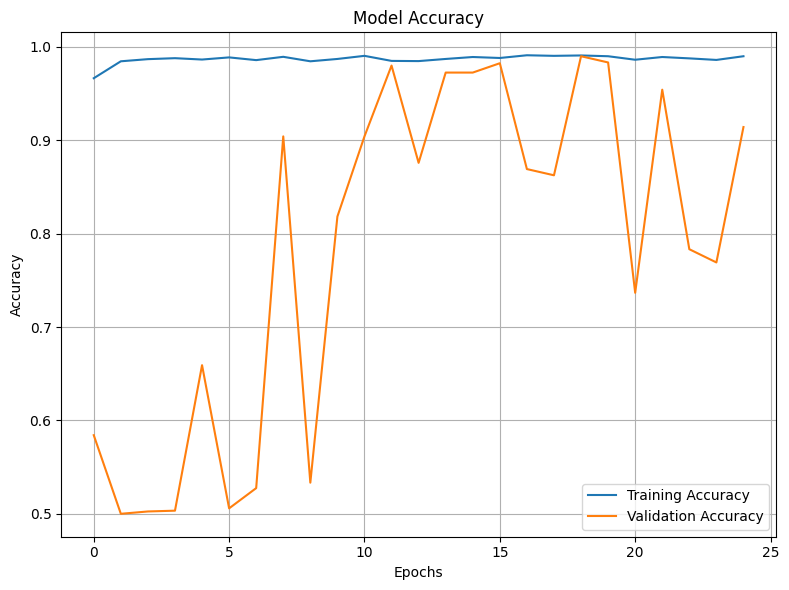

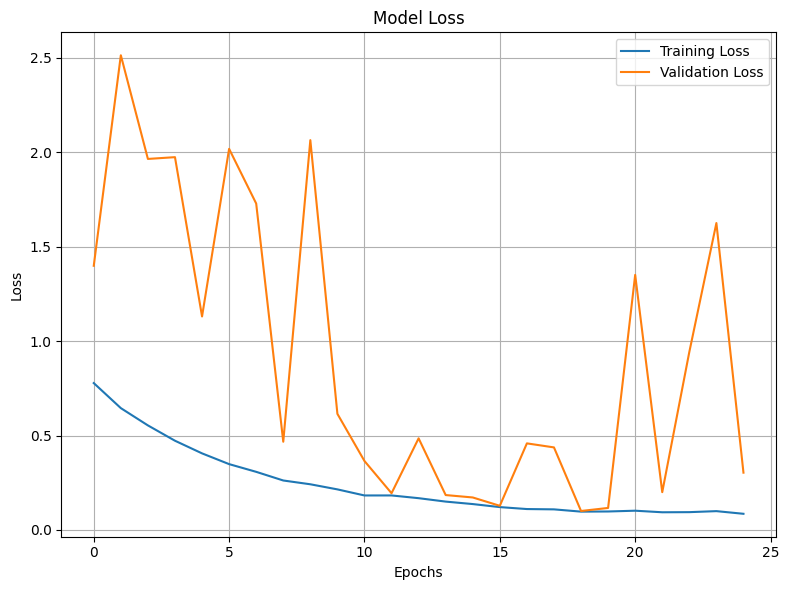

In [217]:
display_keras_history(validation_generator, model, fit)

## Display Metrics

Evaluating Keras model...


/Users/isaacdavis/Desktop/PersonalStuff/MyProjects/GitHub/AI/agriculture_detection/env/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/st ━━━━━━━━━

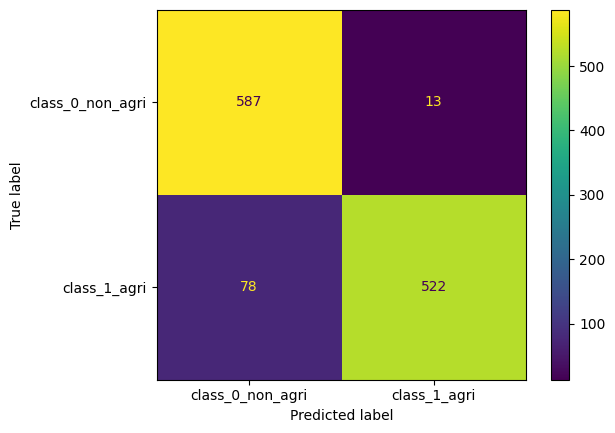

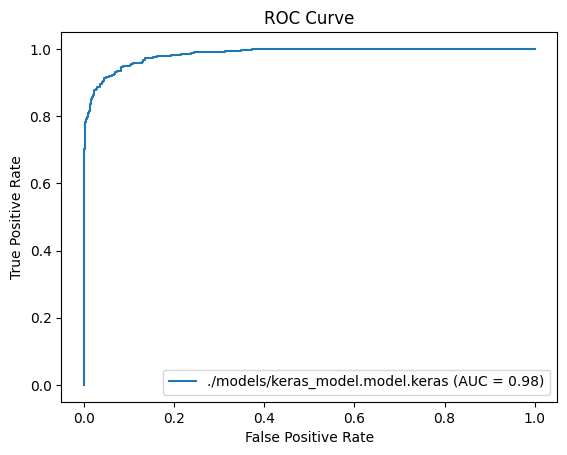

In [216]:
evaluate_keras_model(model, validation_generator, device, model_name)